# Sex Classification from High-Frequency Sleep Stage Features

This notebook evaluates whether high-frequency sleep staging captures sex-related
information by training random forest classifiers on sleep stage transition patterns.

## Method

1. **Load high-frequency predictions** from `predict-high-freq.py` sweep
   - Path: `logs/exp002/exp002a/sweep-*/`
   - Multiple temporal resolutions (1-3840 predictions per 30s epoch)

2. **Extract triplet features** from sleep stage sequences
   - Count occurrences of stage transition triplets (e.g., "Wake→N1→N2")
   - Features computed per 3-minute blocks during sleep
   - 80 possible triplet patterns (excluding self-transitions)

3. **Train random forest classifier** with leave-one-subject-out CV
   - 50 experiments with randomized hyperparameters (from `rnd_parameter_map_rndfcls.json`)
   - Balanced class weights to handle sex imbalance
   - Binary classification: Female=0, Male=1

4. **Evaluate with Macro F1** at each temporal resolution
   - Compare against random baseline (~0.5 MF1)

## Data Requirements

- High-frequency prediction sweep: `logs/exp002/exp002a/sweep-*_isruc/`
- ISRUC metadata: `../final-figures/isruc-info/Details_subgroup_*_Submission.xlsx`
- Hyperparameter configs: `rnd_parameter_map_rndfcls.json`

## Output

Results (MF1 per model/resolution) are manually copied to:
- `../final-figures/hf_scores.py` → `isruc_sex` dictionary

Used by `../final-figures/high-freq-panels.ipynb` for visualization.

In [1]:
import glob
import json
from functools import partial
from os.path import dirname

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def calc_mode(data, axis=0):
    bins = np.apply_along_axis(
        lambda x: np.bincount(x, minlength=5), axis=axis, arr=data
    )
    # resolve ties randomly by adding a small random number to the counts
    rand_mat = np.random.random_sample(bins.shape)
    bins = bins + rand_mat
    return np.argmax(bins, axis=axis)


usleep_isruc_path = "../../logs/exp002/exp002a/sweep-2025-07-29_18-44-18_isruc/"
usleep_isruc_labels_glob = f"{usleep_isruc_path}/*/labels.npz"
usleep_isruc_preds_glob = f"{usleep_isruc_path}/*/predictions.npz"
usleep_isruc_labels_files = sorted(glob.glob(usleep_isruc_labels_glob), key=lambda x: int(x.split("/")[-2]))
usleep_isruc_preds_files = sorted(glob.glob(usleep_isruc_preds_glob), key=lambda x: int(x.split("/")[-2]))

files_per_run_per_sr = {}
for label_file, pred_file in zip(usleep_isruc_labels_files, usleep_isruc_preds_files):
    with open(dirname(label_file) + "/predict-high-freq.log") as f:
        lines = f.readlines()
        sr_line = [line for line in lines if "sleep_stage_frequency" in line][0]
        sleep_stage_sr = int(sr_line.split("=")[1])
        model_run = [line for line in lines if "model.path=" in line][0]
        model_run = model_run.split("=")[1].strip()
    if model_run not in files_per_run_per_sr:
        files_per_run_per_sr[model_run] = {}
    files_per_run_per_sr[model_run][sleep_stage_sr] = (label_file, pred_file)

epoch_sr = 128 * 30
n_classes = 5
feature_block_duration = int(1.5 * 60 * 2)  # in epochs
possible_triplets = [f"{i}{j}{k}" for i in range(n_classes) for j in range(n_classes) for k in range(n_classes)
                     if i != j and j != k]


def calc_features(sleep_sr, pred_file, preds_per_epoch):
    features = {}
    preds_dict = np.load(pred_file)

    for rec in preds_dict.keys():
        preds = preds_dict[rec]

        sleep_start = np.where(preds_per_epoch[rec] != 0)[0][0]
        sleep_end = np.where(preds_per_epoch[rec] != 0)[0][-1]

        features[rec] = []
        for i in range(sleep_start, sleep_end, feature_block_duration):
            features[rec].append([0] * len(possible_triplets))
            features_block = preds[i * sleep_sr:min(i + feature_block_duration, sleep_end) * sleep_sr]
            features_block_1r = np.r_[features_block[0], features_block[:-1]]
            features_block_1l = np.r_[features_block[1:], features_block[-1]]

            # find triplets with a different element in the middle
            triplet_mask = np.where(((features_block - features_block_1r) != 0)
                                    & ((features_block - features_block_1l) != 0))[0]

            for trip_idx in triplet_mask:
                trip_str = f"{features_block[trip_idx - 1]}{features_block[trip_idx]}{features_block[trip_idx + 1]}"
                features[rec][-1][possible_triplets.index(trip_str)] += 1

    return features

In [2]:
metadata_files = ["../final-figures/isruc-info/Details_subgroup_I_Submission.xlsx",
                  "../final-figures/isruc-info/Details_subgroup_II_Submission.xlsx",
                  "../final-figures/isruc-info/Details_subgroup_III_Submission.xlsx"]
subj_sex_dict = {}
for metadata_file in metadata_files:
    metadata = pd.read_excel(metadata_file, header=2)[["Subject", "Sex"]]
    metadata = metadata[metadata["Sex"].astype(str).str.match("F|M")]
    metadata["Subject"] = f"isruc-sg{len(metadata_file.split('_')[-2])}_" + metadata["Subject"].astype(str).str.replace(
        "Rec.", "")
    metadata["Sex"] = metadata["Sex"].astype(str).str.replace("F", "0").str.replace("M", "1").astype(int)
    subj_sex_dict.update(metadata.set_index("Subject")["Sex"].to_dict())
subj_sex_dict.update({k[:-1] + "2": v for k, v in subj_sex_dict.items() if "isruc-sg2_" in k})
subj_sex_dict

{'isruc-sg1_1': 1,
 'isruc-sg1_2': 1,
 'isruc-sg1_3': 1,
 'isruc-sg1_4': 1,
 'isruc-sg1_5': 0,
 'isruc-sg1_6': 1,
 'isruc-sg1_7': 1,
 'isruc-sg1_8': 1,
 'isruc-sg1_9': 1,
 'isruc-sg1_10': 0,
 'isruc-sg1_11': 1,
 'isruc-sg1_12': 1,
 'isruc-sg1_13': 1,
 'isruc-sg1_14': 1,
 'isruc-sg1_15': 1,
 'isruc-sg1_16': 1,
 'isruc-sg1_17': 1,
 'isruc-sg1_18': 1,
 'isruc-sg1_19': 0,
 'isruc-sg1_20': 1,
 'isruc-sg1_21': 0,
 'isruc-sg1_22': 1,
 'isruc-sg1_23': 0,
 'isruc-sg1_24': 1,
 'isruc-sg1_25': 0,
 'isruc-sg1_26': 1,
 'isruc-sg1_27': 0,
 'isruc-sg1_28': 0,
 'isruc-sg1_29': 0,
 'isruc-sg1_30': 1,
 'isruc-sg1_31': 1,
 'isruc-sg1_32': 1,
 'isruc-sg1_33': 0,
 'isruc-sg1_34': 0,
 'isruc-sg1_35': 1,
 'isruc-sg1_36': 0,
 'isruc-sg1_37': 1,
 'isruc-sg1_38': 1,
 'isruc-sg1_39': 1,
 'isruc-sg1_40': 0,
 'isruc-sg1_41': 0,
 'isruc-sg1_42': 0,
 'isruc-sg1_43': 0,
 'isruc-sg1_44': 0,
 'isruc-sg1_45': 0,
 'isruc-sg1_46': 1,
 'isruc-sg1_47': 1,
 'isruc-sg1_48': 0,
 'isruc-sg1_49': 1,
 'isruc-sg1_50': 1,
 'isruc-s

In [3]:
from sklearn.ensemble import RandomForestClassifier
from concurrent.futures import ProcessPoolExecutor


def train_and_predict(features, n_exps):
    x_data = []
    y_data = []
    subject_mapping = []

    for subject_name, subj_features in features.items():
        if subject_name not in subj_sex_dict:
            print(f"No Sex for {subject_name}")
            continue
        x_data.extend(subj_features)
        y_data.extend([subj_sex_dict[subject_name]] * len(subj_features))
        subject_mapping.extend([subject_name] * len(subj_features))

    x_data = np.array(x_data)
    y_data = np.array(y_data)
    subject_mapping = np.array(subject_mapping)

    label_age = []
    predict_age = []
    for run_num in range(n_exps):
        label_age.append([])
        predict_age.append([])

        with ProcessPoolExecutor(max_workers=32) as executor:
            partial_f = partial(fit_and_predict, run_num, x_data, y_data, subject_mapping)
            results = list(executor.map(partial_f, np.unique(subject_mapping)))
            for label, pred in results:
                label_age[-1].append(label)
                predict_age[-1].append(pred)

    return label_age, predict_age


with open("rnd_parameter_map_rndfcls.json", "r") as f:
    rnd_parameter_map = json.load(f)


def fit_and_predict(run_num, x_data, y_data, subject_mapping, subj):
    x_train = x_data[subject_mapping != subj].copy()
    y_train = y_data[subject_mapping != subj].copy()
    x_test = x_data[subject_mapping == subj].copy()
    y_test = y_data[subject_mapping == subj].copy()

    clf = RandomForestClassifier(n_estimators=200, criterion="gini", class_weight="balanced",
                                 max_depth=rnd_parameter_map[run_num]["max_tree_depth"],
                                 min_samples_leaf=rnd_parameter_map[run_num]["min_samples_leaf"],
                                 min_samples_split=rnd_parameter_map[run_num]["min_samples_split"],
                                 max_features=rnd_parameter_map[run_num]["max_features"])
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    return y_test[0], np.mean(y_pred)

In [4]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

n_exps = 50

mf1_scores = {}
for model_run, files_per_sr in files_per_run_per_sr.items():
    print(f"Model epoch: {model_run}")
    preds_per_epoch = np.load(files_per_sr[1][1])
    mf1_scores[model_run] = {}
    for sleep_stage_sr, files in files_per_sr.items():
        features = calc_features(sleep_stage_sr, files[1], preds_per_epoch)
        label_age, predict_age = train_and_predict(features, n_exps)

        predict_age = np.array(predict_age)
        label_age = np.array(label_age)

        predict_sex_bin = (predict_age > 0.5).astype(int)
        predict_sex_bin[predict_age == 0.5] = np.random.randint(0, 2, size=np.sum(predict_age == 0.5))

        f1_array = []
        for i_exp in range(n_exps):
            cm = confusion_matrix(label_age[i_exp], predict_sex_bin[i_exp])
            precs, recs, f1s, _ = precision_recall_fscore_support(label_age[i_exp], predict_sex_bin[i_exp],
                                                                  average=None)
            f1_array.append(np.mean(f1s))

        print(f"{sleep_stage_sr} sleep stages per epoch")
        print(f"Avg. Makro F1: {np.mean(f1_array)}")
        print(f"Std. Makro F1: {np.std(f1_array)}")
        print()
        mf1_scores[model_run][sleep_stage_sr] = f1_array


Model epoch: griegeru_hs40.pth


1 sleep stages per epoch
Avg. Makro F1: 0.5453230643682656
Std. Makro F1: 0.026129035442768723



2 sleep stages per epoch
Avg. Makro F1: 0.5908581238032009
Std. Makro F1: 0.02479514255500628



4 sleep stages per epoch
Avg. Makro F1: 0.5235506311477071
Std. Makro F1: 0.036686480253057145



8 sleep stages per epoch
Avg. Makro F1: 0.5225402261719357
Std. Makro F1: 0.021922803982083964



16 sleep stages per epoch
Avg. Makro F1: 0.5493103149195563
Std. Makro F1: 0.040006308557025444



32 sleep stages per epoch
Avg. Makro F1: 0.5392955193566263
Std. Makro F1: 0.033318322491540826



64 sleep stages per epoch
Avg. Makro F1: 0.6218740160757019
Std. Makro F1: 0.05103341206089335



128 sleep stages per epoch
Avg. Makro F1: 0.6078574090031817
Std. Makro F1: 0.0291030678134126



256 sleep stages per epoch
Avg. Makro F1: 0.6116028443203334
Std. Makro F1: 0.027395763869328075



384 sleep stages per epoch
Avg. Makro F1: 0.626244643241004
Std. Makro F1: 0.020016264045199763



640 sleep stages per epoch
Avg. Makro F1: 0.631865440319449
Std. Makro F1: 0.021091279467177617



960 sleep stages per epoch
Avg. Makro F1: 0.6354408550281834
Std. Makro F1: 0.01900661730074082



1920 sleep stages per epoch
Avg. Makro F1: 0.5883275840199989
Std. Makro F1: 0.015513065667238353



3840 sleep stages per epoch
Avg. Makro F1: 0.6393531144002735
Std. Makro F1: 0.022400303255485608

Model epoch: train-usleep-2025-07-21_12-03-51-final.pth


1 sleep stages per epoch
Avg. Makro F1: 0.5081114306673136
Std. Makro F1: 0.02380340074129201



2 sleep stages per epoch
Avg. Makro F1: 0.5126867937059627
Std. Makro F1: 0.035183670260312015



4 sleep stages per epoch
Avg. Makro F1: 0.49175138404654506
Std. Makro F1: 0.02501701393243665



8 sleep stages per epoch
Avg. Makro F1: 0.5589054782377512
Std. Makro F1: 0.02362046574151224



16 sleep stages per epoch
Avg. Makro F1: 0.5105132623083898
Std. Makro F1: 0.025777535912220567



32 sleep stages per epoch
Avg. Makro F1: 0.5184467059738216
Std. Makro F1: 0.027836061839866987



64 sleep stages per epoch
Avg. Makro F1: 0.5660484066262936
Std. Makro F1: 0.0318427509633353



128 sleep stages per epoch
Avg. Makro F1: 0.5705596415976065
Std. Makro F1: 0.02758420608872649



256 sleep stages per epoch
Avg. Makro F1: 0.5884891389296802
Std. Makro F1: 0.043364874890489936



384 sleep stages per epoch
Avg. Makro F1: 0.5857033788886024
Std. Makro F1: 0.019568803695841096



640 sleep stages per epoch
Avg. Makro F1: 0.5616800283543448
Std. Makro F1: 0.028418164924924452



960 sleep stages per epoch
Avg. Makro F1: 0.5587451954616762
Std. Makro F1: 0.03919388269238164



1920 sleep stages per epoch
Avg. Makro F1: 0.5204559821269988
Std. Makro F1: 0.026289382589418646



3840 sleep stages per epoch
Avg. Makro F1: 0.5528467861311408
Std. Makro F1: 0.02619937529556548

Model epoch: train-usleep-2025-07-21_12-04-20-final.pth


1 sleep stages per epoch
Avg. Makro F1: 0.4213013869799945
Std. Makro F1: 0.03545128180026473



2 sleep stages per epoch
Avg. Makro F1: 0.4915820374236055
Std. Makro F1: 0.0261181569422604



4 sleep stages per epoch
Avg. Makro F1: 0.5509428019956023
Std. Makro F1: 0.01874387056522299



8 sleep stages per epoch
Avg. Makro F1: 0.623107145795152
Std. Makro F1: 0.02858902384918709



16 sleep stages per epoch
Avg. Makro F1: 0.559202316482149
Std. Makro F1: 0.030725091128184227



32 sleep stages per epoch
Avg. Makro F1: 0.5928226964895115
Std. Makro F1: 0.05345261744594396



64 sleep stages per epoch
Avg. Makro F1: 0.6044723867177614
Std. Makro F1: 0.050545156609873076



128 sleep stages per epoch
Avg. Makro F1: 0.5770309116494579
Std. Makro F1: 0.032433086278742085



256 sleep stages per epoch
Avg. Makro F1: 0.5986785916825142
Std. Makro F1: 0.03610859182807598



384 sleep stages per epoch
Avg. Makro F1: 0.6011063370880021
Std. Makro F1: 0.04827502854354201



640 sleep stages per epoch
Avg. Makro F1: 0.5973613639402707
Std. Makro F1: 0.038728439872471876



960 sleep stages per epoch
Avg. Makro F1: 0.6071069314029179
Std. Makro F1: 0.03840885005416794



1920 sleep stages per epoch
Avg. Makro F1: 0.5883287965390707
Std. Makro F1: 0.037690047427206996



3840 sleep stages per epoch
Avg. Makro F1: 0.5670766145768887
Std. Makro F1: 0.033579328880110004

Model epoch: train-usleep-2025-07-21_12-04-54-final.pth


1 sleep stages per epoch
Avg. Makro F1: 0.5695382715373265
Std. Makro F1: 0.029780925334235982



2 sleep stages per epoch
Avg. Makro F1: 0.48231013127371236
Std. Makro F1: 0.027052182266433755



4 sleep stages per epoch
Avg. Makro F1: 0.5401181871258551
Std. Makro F1: 0.026258406857923276



8 sleep stages per epoch
Avg. Makro F1: 0.5179876899661191
Std. Makro F1: 0.020467600408483295



16 sleep stages per epoch
Avg. Makro F1: 0.5589279348612907
Std. Makro F1: 0.032430636933737475



32 sleep stages per epoch
Avg. Makro F1: 0.5512421402355342
Std. Makro F1: 0.022806673315116464



64 sleep stages per epoch
Avg. Makro F1: 0.6153527081553394
Std. Makro F1: 0.040189271457193594



128 sleep stages per epoch
Avg. Makro F1: 0.6163002445589558
Std. Makro F1: 0.04894676289785122



256 sleep stages per epoch
Avg. Makro F1: 0.5748485297011561
Std. Makro F1: 0.06332071911612175



384 sleep stages per epoch
Avg. Makro F1: 0.5809972791865526
Std. Makro F1: 0.05596713264673168



640 sleep stages per epoch
Avg. Makro F1: 0.5889063172977843
Std. Makro F1: 0.04357693801178688



960 sleep stages per epoch
Avg. Makro F1: 0.5686602122181731
Std. Makro F1: 0.028216403631519248



1920 sleep stages per epoch
Avg. Makro F1: 0.5748588422259963
Std. Makro F1: 0.03194823813982125



3840 sleep stages per epoch
Avg. Makro F1: 0.6143493850147128
Std. Makro F1: 0.037297659456507745



In [5]:
print(mf1_scores)

{'griegeru_hs40.pth': {1: [np.float64(0.5761345604569978), np.float64(0.537819377687832), np.float64(0.5545454545454546), np.float64(0.546218487394958), np.float64(0.5787016592013122), np.float64(0.5314804310833806), np.float64(0.5238095238095238), np.float64(0.5696939033645332), np.float64(0.5537566405261827), np.float64(0.4992114062204277), np.float64(0.5473624503686898), np.float64(0.5386363636363636), np.float64(0.546218487394958), np.float64(0.4740703263344296), np.float64(0.5155984117980714), np.float64(0.5396825396825397), np.float64(0.6142857142857143), np.float64(0.578062804068996), np.float64(0.5314804310833806), np.float64(0.5772079772079772), np.float64(0.53921815889029), np.float64(0.5733179988499137), np.float64(0.5151094568166046), np.float64(0.530296329057939), np.float64(0.5469055580089585), np.float64(0.5704545454545455), np.float64(0.5354691075514875), np.float64(0.546218487394958), np.float64(0.5761345604569978), np.float64(0.52079107505071), np.float64(0.5441447159

In [6]:
# add a random chance baseline
mf1_scores_random_base = []
for i in range(n_exps):
    preds = []
    labels = []
    for subject_name in subj_sex_dict.keys():
        preds.append(np.random.choice([0, 1]))
        labels.append(subj_sex_dict[subject_name])

    precs, recs, f1s, _ = precision_recall_fscore_support(labels, preds, average=None)
    mf1_scores_random_base.append(np.mean(f1s))

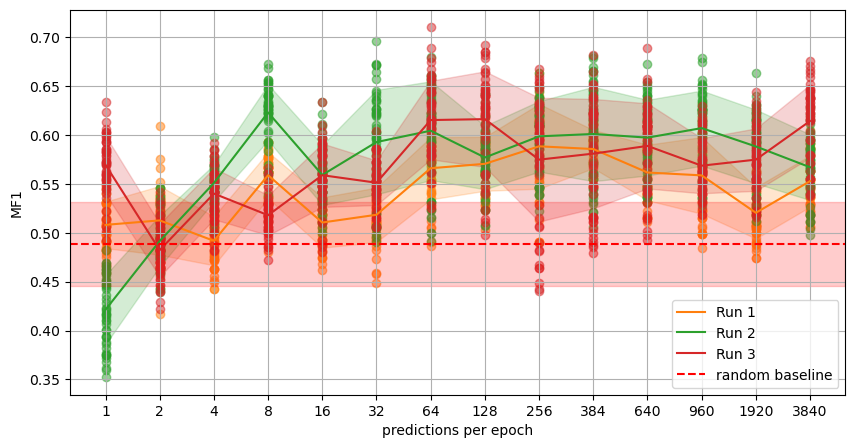

In [7]:
plt.figure(figsize=(10, 5))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
for i, (model_run, mf1_scores_epoch) in enumerate(mf1_scores.items()):
    if model_run == "griegeru_hs40.pth":
        continue
    c = colors[i % len(colors)]
    means_to_plot = np.array(list(mf1_scores_epoch.values())).mean(axis=1)
    stds_to_plot = np.array(list(mf1_scores_epoch.values())).std(axis=1)
    plt.plot(range(len(mf1_scores_epoch)), means_to_plot, label=f"Run {i}", color=c)
    plt.fill_between(range(len(mf1_scores_epoch)), means_to_plot - stds_to_plot, means_to_plot + stds_to_plot,
                     alpha=0.2, color=c)
    plt.scatter(np.repeat(range(len(mf1_scores_epoch)), n_exps), np.array(list(mf1_scores_epoch.values())).flatten(),
                alpha=0.5, color=c)

x_low_lim, x_high_lim = plt.xlim()
plt.axhline(np.mean(mf1_scores_random_base), ls="--", c="r", label="random baseline")
# plt.axhline(np.mean(mf1_scores_random_base) - np.std(mf1_scores_random_base), ls="--", c="r", alpha=0.5)
# plt.axhline(np.mean(mf1_scores_random_base) + np.std(mf1_scores_random_base), ls="--", c="r", alpha=0.5)
plt.fill_between([x_low_lim, x_high_lim], np.mean(mf1_scores_random_base) - np.std(mf1_scores_random_base),
                 np.mean(mf1_scores_random_base) + np.std(mf1_scores_random_base), alpha=0.2, color="r")

first_key = next(iter(mf1_scores))
plt.xticks(range(len(mf1_scores[first_key])), list(mf1_scores[first_key].keys()))
plt.grid()
plt.xlim([x_low_lim, x_high_lim])
plt.xlabel("predictions per epoch")
plt.ylabel("MF1")
plt.legend()
plt.show()